# Import libraires, data et paramètres

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

In [203]:
# Load the data
data1 = np.loadtxt('P2024_f_eps_Part3.txt')
nat_freq = data1[:, 0]
damping_ratios = data1[:, 1]
damping_ratios_pt2 = np.full(len(damping_ratios), 0.02)

modes = np.loadtxt('P2024_modes_Part3.txt')
modes /= 1000  # passage de mm à m

data3 = np.loadtxt('P2024_frf_Part3_f_ds.txt')
frf_freq = data3[:, 0]
frf_re = data3[:, 1]
frf_im = data3[:, 2]

In [204]:
# Parameters
F0 = 450
wavelength = 0.2
speed_kph = 50

Omega = 2*np.pi*speed_kph/(3.6*wavelength)


def F_Z(t):
    return F0*np.sin(Omega*t)

---

# Partie 1

## Question 1



### Plot de l'excitation harmonique

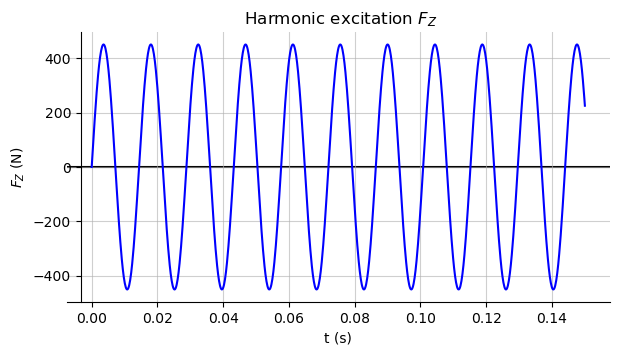

In [205]:
# Plot the harmonic excitation from 0 to 0.15s

t = np.linspace(0, 0.15, 1000)
F = F_Z(t)

fig, ax = plt.subplots(figsize=(7, 4 * 7/8))
ax.plot(t, F, color='blue')
ax.axhline(y=0, color='black', zorder=0)

# Improve axes appearance
ax.spines['top'].set_visible(False)  # Remove top spine
ax.spines['right'].set_visible(False)  # Remove right spine
ax.spines['left'].set_position(('outward', -10))  # Offset left spine
ax.spines['bottom'].set_position(('outward', 0))  # Offset bottom spine

# Axes names
ax.set_xlabel('t (s)')
ax.set_ylabel('$F_Z$ (N)')

# Add grid with transparency
plt.grid(True, alpha=0.6)

# Add a title
plt.title(' Harmonic excitation $F_Z$')

# Show the plot
fig.savefig('Plots/harmonic_excitation.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Question 2

### Calcul de la matrices des FRF en accélération

In [206]:
def FRF_matrix(freq, part):

    if part == 1:
        damp_r = damping_ratios
    elif part == 2:
        damp_r = damping_ratios_pt2

    H = np.zeros((len(modes), len(modes)), dtype=complex)

    omega = 2*np.pi*freq

    nat_f = 2*np.pi*nat_freq

    for k in range(len(nat_freq)):

        denominator = nat_f[k]**2 - omega**2 + \
            2j * damp_r[k]*omega*nat_f[k]

        H += np.outer(modes[:, k], modes[:, k]) * (-omega**2) / denominator

    return H


def FRF_amplitude(freq, part):
    H = FRF_matrix(freq, part)
    return np.abs(H)


def Bode_amp_seat(freq, part):

    H = FRF_matrix(freq, part)

    amplitude = np.abs(H[11, 0])

    return amplitude


def nyq_real(freq):

    H = FRF_matrix(freq, part=1)

    return np.real(H[11, 0])


def nyq_im(freq):

    H = FRF_matrix(freq, part=1)

    return np.imag(H[11, 0])

### Plot diagrammes de Bode et Nyquist

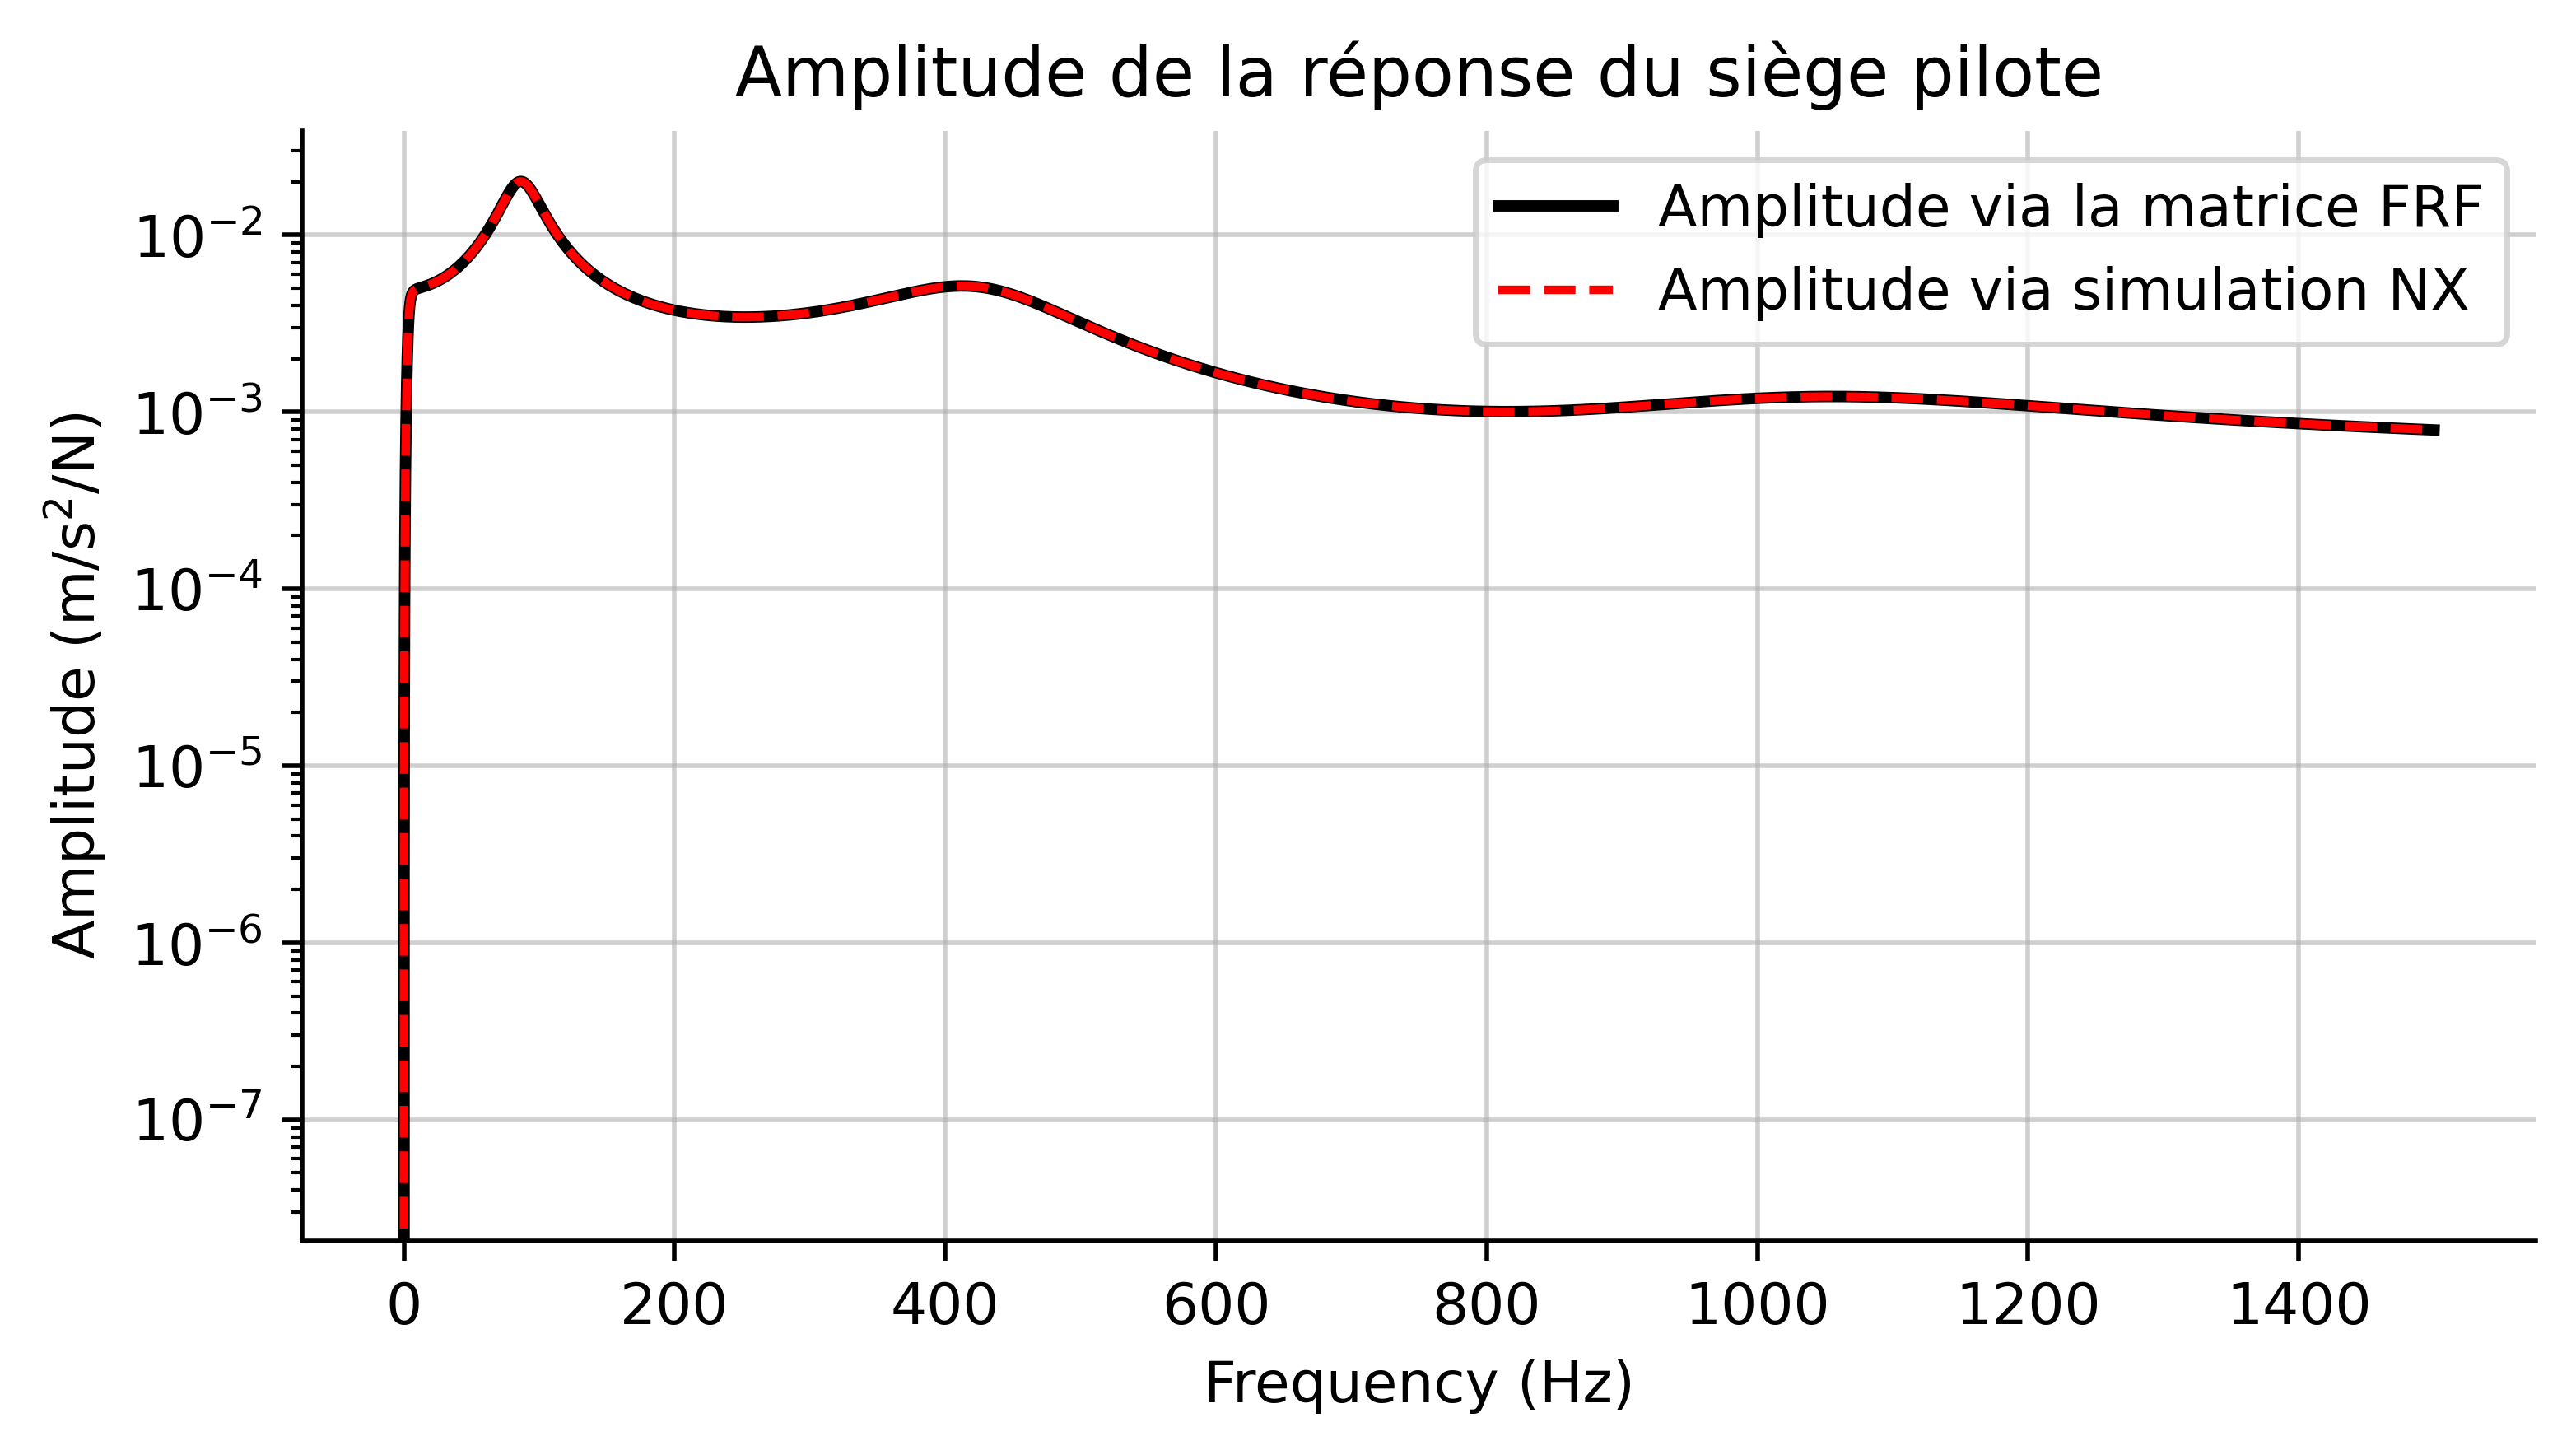

In [207]:
# Bode diagram
frequencies = np.linspace(0, 1500, 20000)
amplitudes = [Bode_amp_seat(f, part=1) for f in frequencies]
# amplitudes = 20* np.log10(amplitudes)

fig, ax = plt.subplots(figsize=(7, 4 * 7/8), dpi=500)

ax.semilogy(frequencies, amplitudes, color='black',
            label='Amplitude via la matrice FRF', linewidth=2)

frf_amplitude = np.abs(frf_re + 1j*frf_im)
ax.semilogy(frf_freq, frf_amplitude, color='red',
            linestyle='--', label='Amplitude via simulation NX')


ax.spines['top'].set_visible(False)  # Remove top spine
ax.spines['right'].set_visible(False)  # Remove right spine
ax.spines['left'].set_position(('outward', 0))  # Offset left spine
ax.spines['bottom'].set_position(('outward', 0))  # Offset bottom spine
ax.grid(True, alpha=0.6)
plt.title('Amplitude de la réponse du siège pilote')
plt.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (m/s$^2$/N)')

plt.savefig('Plots/diagram_bode_Q2.png', dpi=500, bbox_inches='tight')

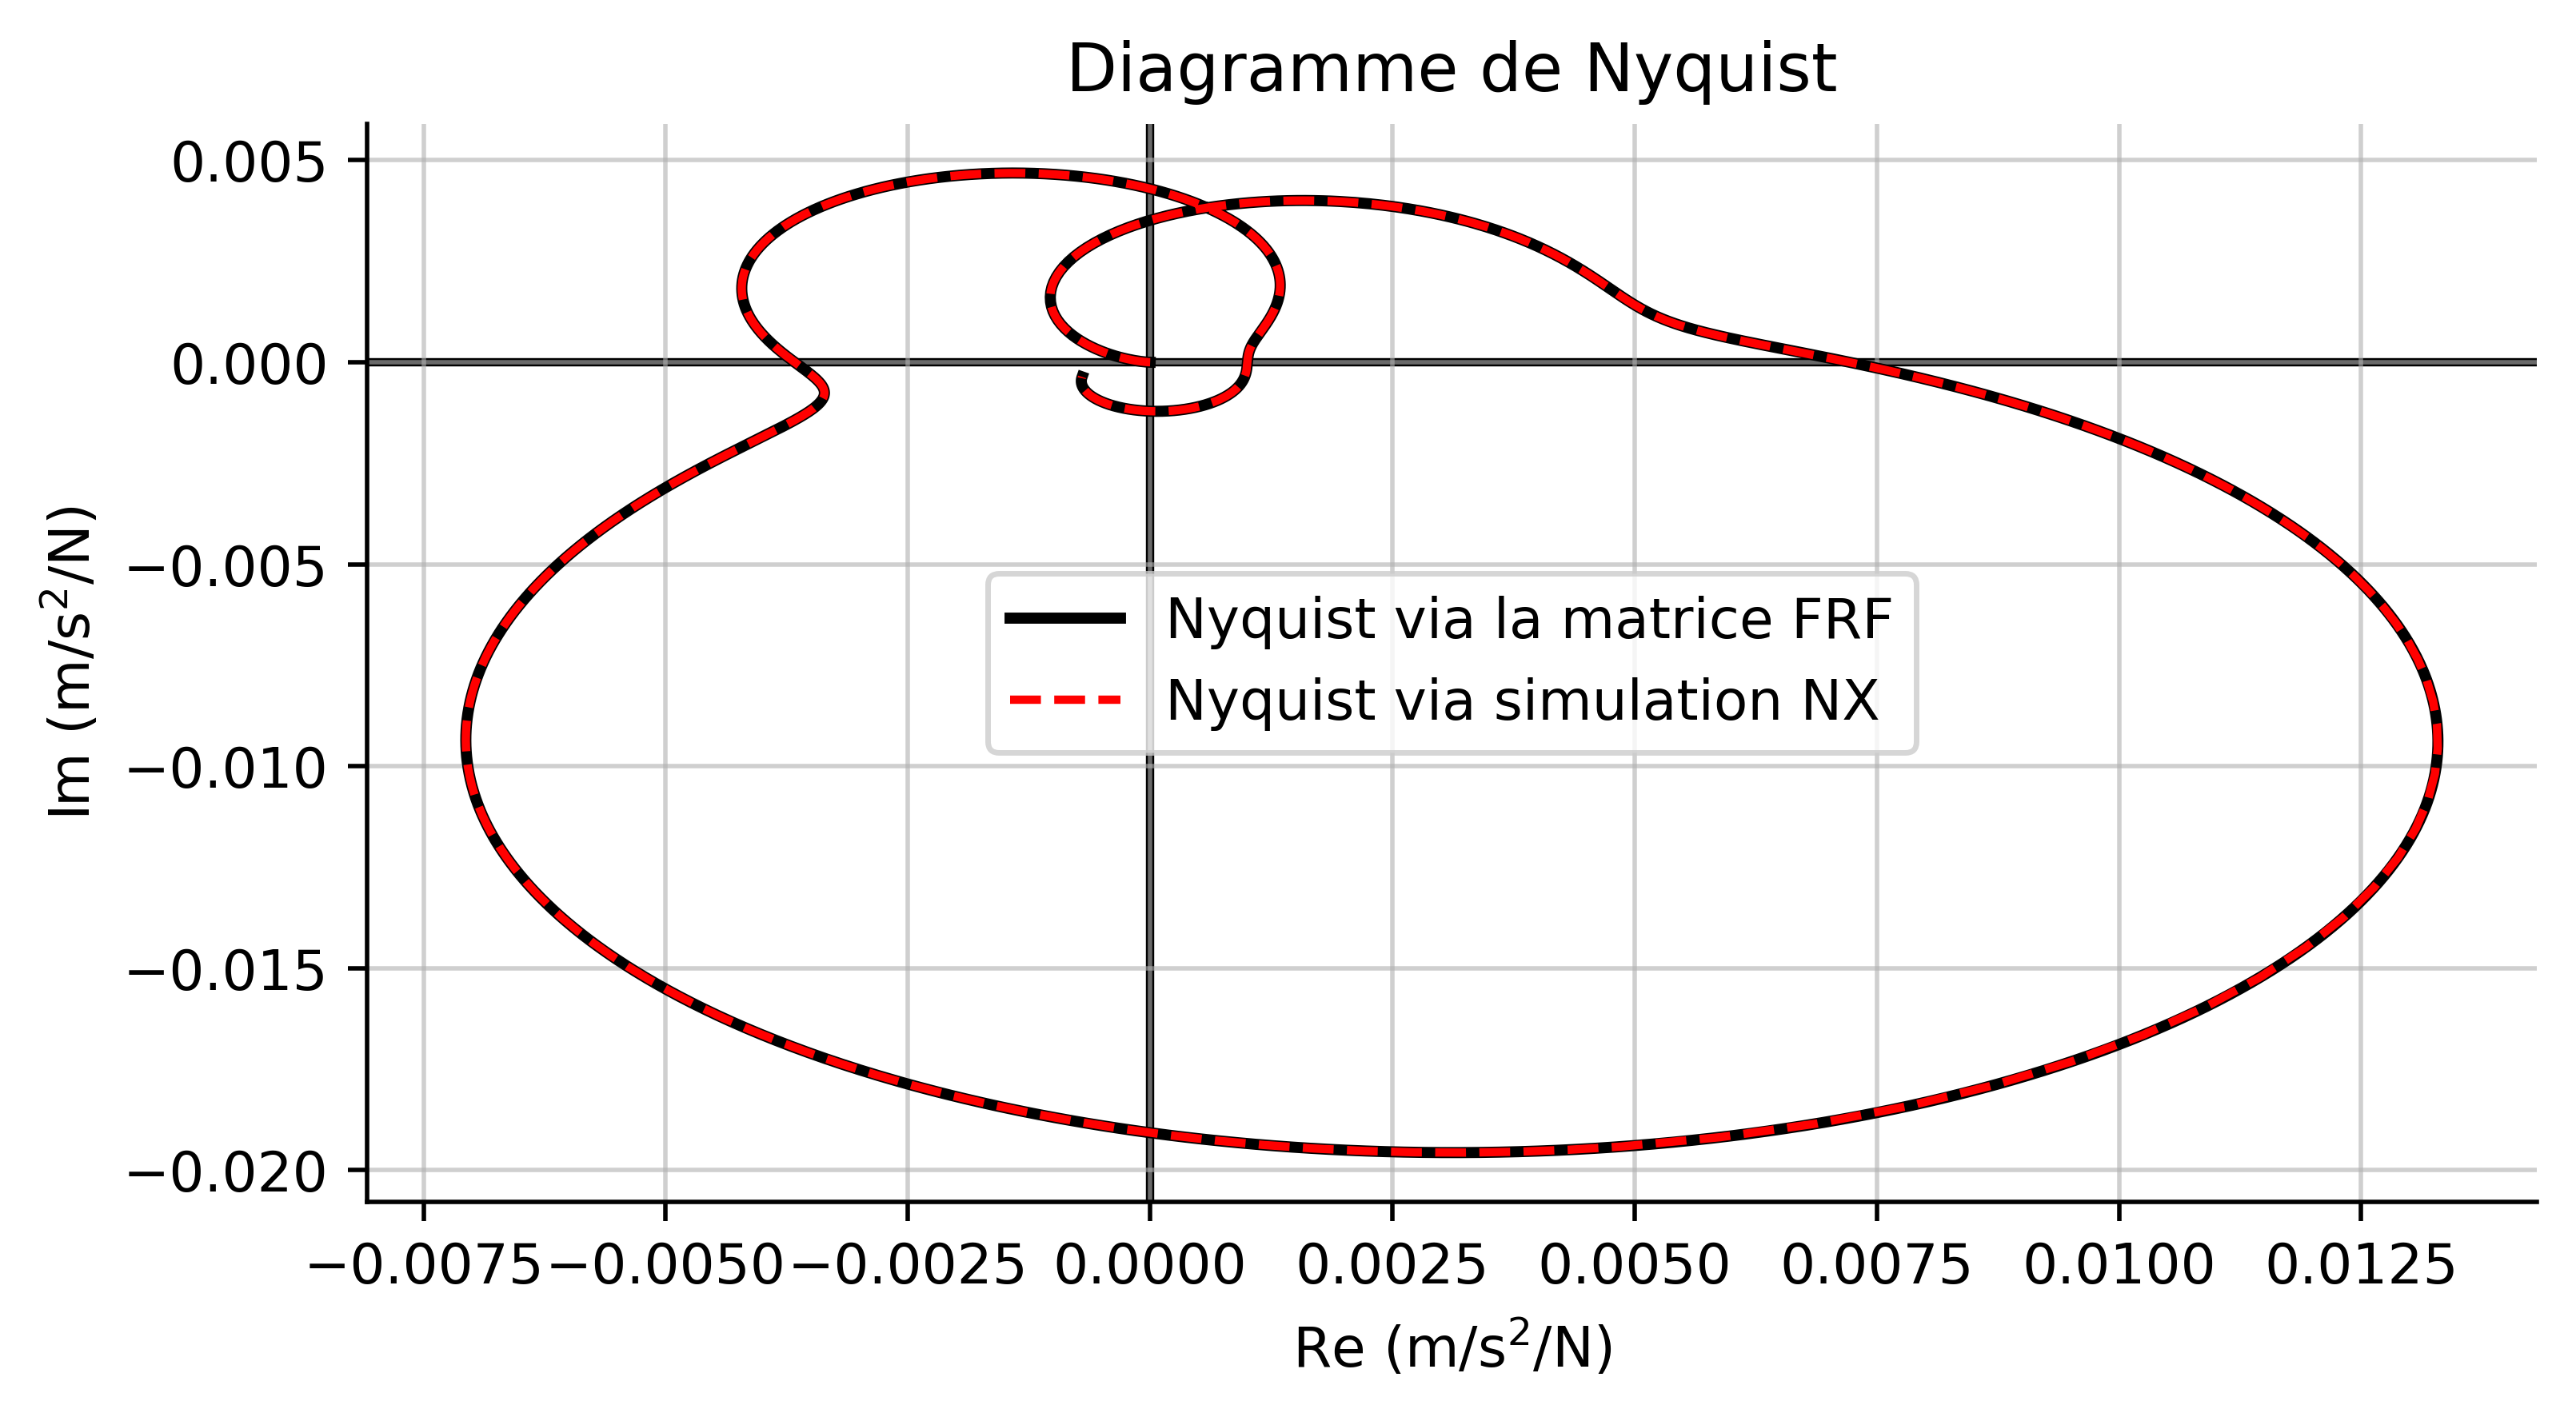

In [208]:
# Nyquist diagram
nyquist_real = [nyq_real(f) for f in frequencies]
nyquist_im = [nyq_im(f) for f in frequencies]

fig, ax = plt.subplots(figsize=(7, 4 * 7/8), dpi=500)

ax.plot(nyquist_real, nyquist_im, color='black',
        label='Nyquist via la matrice FRF', linewidth=2)

ax.plot(frf_re, frf_im, color='red', linestyle='--',
        label='Nyquist via simulation NX')

ax.axhline(y=0, color='black', zorder=0)
ax.axvline(x=0, color='black', zorder=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 0))
ax.spines['bottom'].set_position(('outward', 0))
ax.set_xlabel('Re (m/s$^2$/N)')
ax.set_ylabel('Im (m/s$^2$/N)')
ax.grid(True, alpha=0.6)

plt.title('Diagramme de Nyquist')
plt.legend()

plt.savefig('Plots/diagram_nyquist_Q2.png', dpi=500, bbox_inches='tight')

---

## Question 3 


### Amplitude max de la réponse pour chaque point et montrer l'évolution dans un graphe

[9.4 8.7 6.8 5.  5.4 5.4 7.2 8.2 7.6 5.5 2.2 2.  5.9 9.8]
[0.  0.1 0.2 0.3 0.4 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]


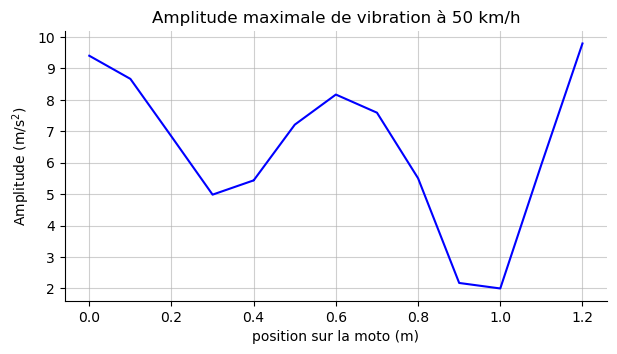

In [209]:
excitation_amp_vector = np.zeros_like(modes[:, 0])
excitation_amp_vector[1] = F0

ampl_vector = np.dot(FRF_amplitude(Omega, part=1), excitation_amp_vector)
print(np.round(ampl_vector, 1))

sensors_pos = np.linspace(0, 1.2, 13)
sensors_pos = np.insert(sensors_pos, 4, 0.4)
print(sensors_pos)

fig, ax = plt.subplots(figsize=(7, 4 * 7/8))
ax.plot(sensors_pos, ampl_vector, color='blue')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 0))
ax.spines['bottom'].set_position(('outward', 0))
plt.grid(True, alpha=0.6)
ax.set_ylabel('Amplitude (m/s$^2$)')
ax.set_xlabel('position sur la moto (m)')

plt.title('Amplitude maximale de vibration à 50 km/h')

plt.savefig('Plots/amplitude_vibration_Q3.png', dpi=500, bbox_inches='tight')

### Plot l'évolution de la réponse en accélération au siège du pilote

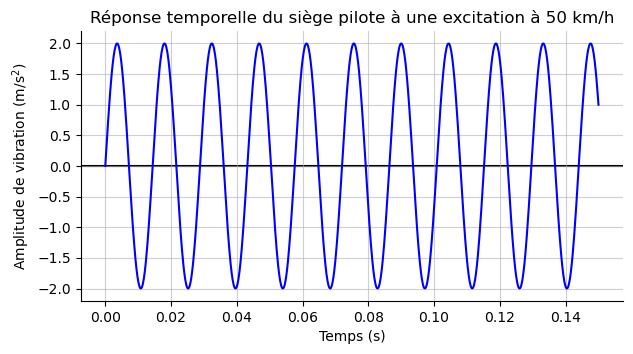

In [210]:
amplitude_driver = ampl_vector[11]
response = amplitude_driver * np.sin(Omega*t)

fig, ax = plt.subplots(figsize=(7, 4 * 7/8))
ax.plot(t, response, color='blue')

ax.axhline(y=0, color='black', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 0))
ax.spines['bottom'].set_position(('outward', 0))
plt.grid(True, alpha=0.6)
ax.set_ylabel('Amplitude de vibration (m/s$^2$)')
ax.set_xlabel('Temps (s)')
plt.title('Réponse temporelle du siège pilote à une excitation à 50 km/h')

plt.savefig('Plots/reponse_temporelle_Q3.png', dpi=500, bbox_inches='tight')

---


# Partie 2

## Question 1

### Fourche bloquée, tous les $\varepsilon$ = 0.02 ; calculer l'amplitude de la réponse du siège pilote à une excitation à la fourche entre 50 et 70 kph

Text(0.5, 1.0, 'Amplitude of the driver seat')

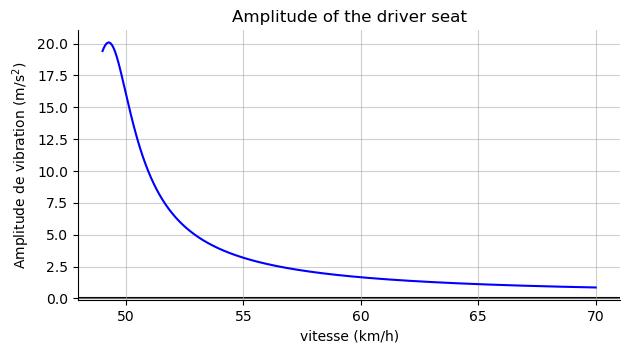

In [211]:
speed_pt2 = np.linspace(49, 70, 5000)
Omega_pt2 = 2*np.pi*speed_pt2/(3.6*wavelength)
amplitude_driver_pt2 = np.zeros_like(speed_pt2)

for i in range(len(speed_pt2)):
    amplitude_driver_pt2[i] = Bode_amp_seat(Omega_pt2[i], part=2) * F0


fig, ax = plt.subplots(figsize=(7, 4 * 7/8))
ax.plot(speed_pt2, amplitude_driver_pt2, color='blue')

ax.axhline(y=0, color='black', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 0))
ax.spines['bottom'].set_position(('outward', 0))
plt.grid(True, alpha=0.6)
ax.set_ylabel('Amplitude de vibration (m/s$^2$)')
ax.set_xlabel('vitesse (km/h)')
plt.title('Amplitude de vibration au siège pilote')


plt.title('Amplitude of the driver seat')

## Question 2

### Fourche bloquée, regarder quelles fréquences sont accentuées et peuvent etre dangereuses pour le corps humain

Text(0, 0.5, 'Amplitude (m/$s^2$)')

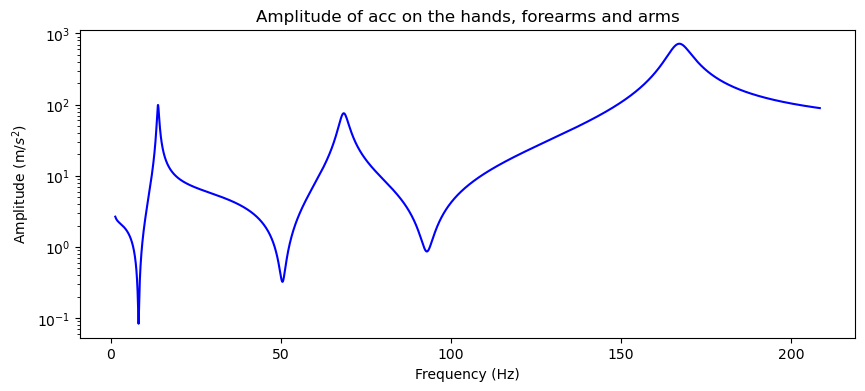

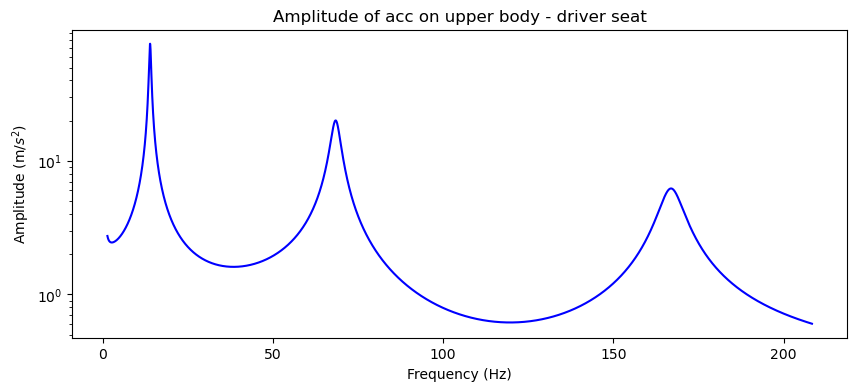

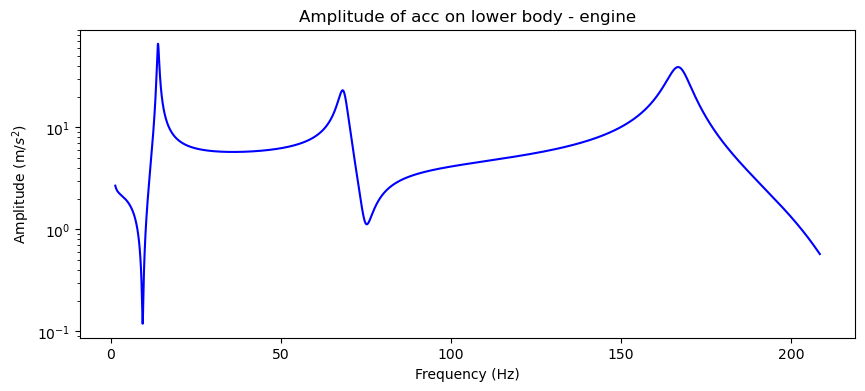

In [212]:
speed_pt2 = np.linspace(1, 150, 5000)
Omega_pt2 = 2*np.pi*speed_pt2/(3.6*wavelength)
freq_pt2 = Omega_pt2/(2*np.pi)

amplitude_sensors_pt2 = np.zeros((len(speed_pt2), len(modes), len(modes)))
for i in range(len(speed_pt2)):
    amplitude_sensors_pt2[i] = FRF_amplitude(Omega_pt2[i], part=2) * F0


# Hands, forearms, arms :
ampl_hands = amplitude_sensors_pt2[:, 0, 0]

fig, ax = plt.subplots(figsize=(10, 4))
ax.semilogy(freq_pt2, ampl_hands, color='blue')
ax.set_title('Amplitude of acc on the hands, forearms and arms')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (m/$s^2$)')

# Upper body ( head,neck, torso, lumbar spine, hips, ):
ampl_head = amplitude_sensors_pt2[:, 11, 0]

fig, ax = plt.subplots(figsize=(10, 4))
ax.semilogy(freq_pt2, ampl_head, color='blue')
ax.set_title('Amplitude of acc on upper body - driver seat')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (m/$s^2$)')

# Lower body (feet, elbows):
ampl_feet = amplitude_sensors_pt2[:, 5, 0]

fig, ax = plt.subplots(figsize=(10, 4))
ax.semilogy(freq_pt2, ampl_feet, color='blue')
ax.set_title('Amplitude of acc on lower body - engine')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (m/$s^2$)')

<h> Les fréquences de résonance sont identiques partout sur la moto.
Les amplitudes sont par contre différentes pour différents endroits, analyser par rapport aux parties du corps et ce qu'elles touchent sur la moto </h>

---